In [127]:
import pandas as pd
import scipy.stats as stats
import numpy as np

## Načtení dat

In [128]:
df = pd.read_pickle('accidents.pkl.gz')
df

,p1,p36,p37,p2a,weekday(p2a),p2b,p6,p7,p8,p9,...,n,o,p,q,r,s,t,p5a,region,date
0,2100160001,4,NaN,2016-01-01,5,55,1,1,0,2,...,711403.0,NaN,Souhlasnýsesměremúseku,Pomalý,554782.0,451622.0,GN_V0.1UIR-ADR_410,1,PHA,2016-01-01
1,2100160002,4,NaN,2016-01-01,5,130,1,3,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PHA,2016-01-01
2,2100160003,5,NaN,2016-01-01,5,100,1,2,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PHA,2016-01-01
3,2100160004,6,NaN,2016-01-01,5,120,9,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PHA,2016-01-01
4,2100160005,6,NaN,2016-01-01,5,2560,2,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PHA,2016-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,190910224060,3,21030.0,2022-12-28,3,835,5,0,0,2,...,NaN,NaN,NaN,NaN,511587.0,NaN,NaN,2,KVK,2022-12-28
2640,190910224148,8,NaN,2022-12-27,2,1900,3,0,6,2,...,NaN,NaN,NaN,NaN,538434.0,554553.0,NaN,1,KVK,2022-12-27
2641,190910224288,6,NaN,2022-12-30,5,1000,3,0,3,2,...,NaN,NaN,NaN,NaN,560464.0,550817.0,NaN,1,KVK,2022-12-30
2642,190910224334,2,210.0,2022-12-30,5,1525,3,0,2,2,...,NaN,NaN,NaN,NaN,560286.0,NaN,NaN,1,KVK,2022-12-30


## Hypotéza 1
>*Na silnicích první třídy se při nehodách umíralo se stejnou pravděpodobností jako na silnicích třetí třídy.*

Vytvořil jsem si sloupec s příznakem jestli nehoda byla fatální nebo ne. Díky tomuto sloupci jsem si vytvořil kontingenční tabulku, kterou jsem pak vložil jako parametr volání funkce `chi2_contingency`. Tato funkce provede $\chi^{2}$ test nad silnicemi první a třetí třídy z kontingenční tabulky. Díky výsledku testu jsem vyvrátil hypotézu a zjistil, že na silnicích první třídy nebyla pravděpodobnost fatální nehody stejná jako na silnicích třetí třídy. Také jsem zjistil, že nehody na silnicích první třídy vedly k úmrtím více než bylo očekáváno. Pro toto zjištění jsem použil výstup `expected` z funkce `chi2_contingency`.

In [129]:
# Create a new column for fatal accidents
df['fatal'] = df['p13a'] > 0

# Prepare the contingency table
contingency_table = pd.crosstab(df['p36'], df['fatal'])

# Filter for first-class (1) and third-class (3) roads only
contingency_table = contingency_table.loc[[1, 3]]

# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Output the results
print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected values: {expected}")

# Interpretation
if p < 0.05:
    print("Na silnicích první třídy se při nehodách umíralo\
           s jinou pravděpodobností než na silnicích třetí třídy.")
else:
    print("Na silnicích první třídy se při nehodách umíralo\
           se stejnou pravděpodobností než na silnicích třetí třídy.")

expected_df = pd.DataFrame(
    expected, index=contingency_table.index, columns=contingency_table.columns
)

actual_fatal_first_class = contingency_table.loc[1, True]
expected_fatal_first_class = expected_df.loc[1, True]

if actual_fatal_first_class > expected_fatal_first_class:
    print("Nehody na silnicích první třídy vedly\
           k více úmrtím než bylo očekáváno.")
else:
    print("Nehody na silnicích první třídy vedly\
           k méně úmrtím než bylo očekáváno.")

## Analýza dat aut značky Škoda a Audi

In [130]:
skoda_df = df[df['p45a'] == 39].reset_index(drop=True)
audi_df = df[df['p45a'] == 2].reset_index(drop=True)

<Axes: ylabel='Frequency'>

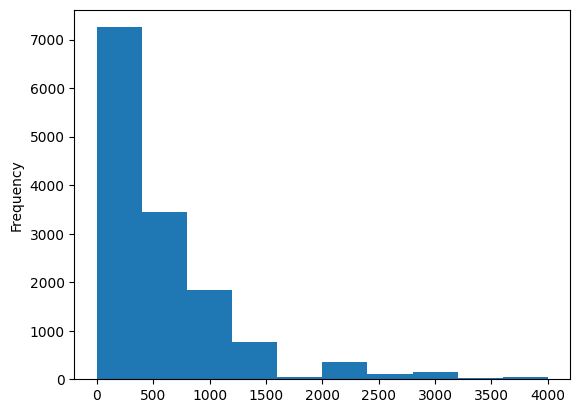

In [131]:
upper_percentile = np.percentile(audi_df['p53'], 99)

# Filter out values beyond the 99th percentile
filtered_prices = audi_df[audi_df['p53'] <= upper_percentile]
filtered_prices['p53'].reset_index(drop=True).plot(kind='hist', label='Audi')

<Axes: ylabel='Frequency'>

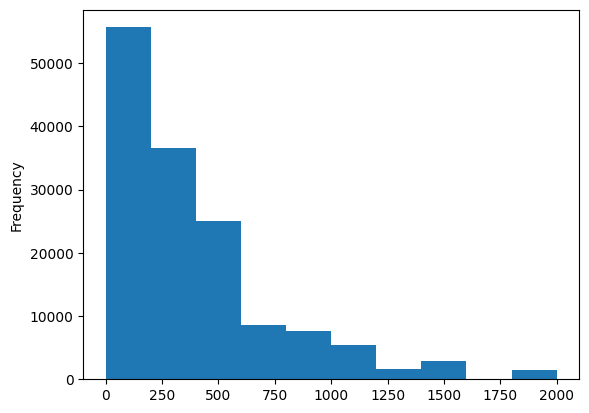

In [132]:
# Define the upper percentile cutoff (e.g., 99th percentile)
upper_percentile = np.percentile(skoda_df['p53'], 99)

# Filter out values beyond the 99th percentile
filtered_prices = skoda_df[skoda_df['p53'] <= upper_percentile]
filtered_prices['p53'].reset_index(drop=True).plot(kind='hist', label='Audi')

## Hypotéza 2
>*Při nehodách vozidel značky Škoda je škoda na vozidle nižší než při nehodách vozidel Audi.*

Z předchozí analýzy dat nehod, kde vozidla byly značky Škoda a Audi jsem zjistil že rozložení škody na vozidle není dle normálního rozdělení (viz. grafy výše). Proto jsem zvolil pro ověření hypotézy test Mann Whitney U-test. Po zavolání funkce `mannwhitneyu` jsme potvrdili hypotézu.

In [133]:
# Perform the Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(
    skoda_df['p53'], audi_df['p53'], alternative='less'
)

# Output the results
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Při nehodách vozidel značky Škoda je škoda\
           na vozidle nižší než při nehodách vozidel Audi.")
else:
    print("Při nehodách vozidel značky Škoda je škoda\
           na vozidle vyšší než při nehodách vozidel Audi.")